# Inference of Text to Image Network

In [1]:
import torch
import lightning as L
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from datasets import SuperresolutionEMNIST
from cINN import ConditionalRealNVPImageTranslator
from autoencoder import AutoencoderSimple, Autoencoder12x12
from classifier import CNN
from utils import get_best_device

## Load pretrained models

In [2]:
autoencoder_12x12 = Autoencoder12x12()
autoencoder_12x12.load_state_dict(torch.load("./models/ae_emnist_mini.pth", map_location=get_best_device()))

autoencoder_28x28 = AutoencoderSimple()
autoencoder_28x28.load_state_dict(torch.load("./models/ae_emnist.pth", map_location=get_best_device()))

<All keys matched successfully>

In [3]:
cinn = ConditionalRealNVPImageTranslator(input_size=64, hidden_size=128, n_blocks=20, condition_size=64)
cinn.load_state_dict(torch.load('./models/cinn_superresolution_emnist.pth'))


<All keys matched successfully>

In [4]:
classifier_path = "./models/classifier_128.pth"
classifier = CNN()
classifier.load_state_dict(torch.load(classifier_path, map_location=get_best_device()))

<All keys matched successfully>

In [21]:
test_data = SuperresolutionEMNIST(train=False, split="byclass")
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

## Sample with Condition

36


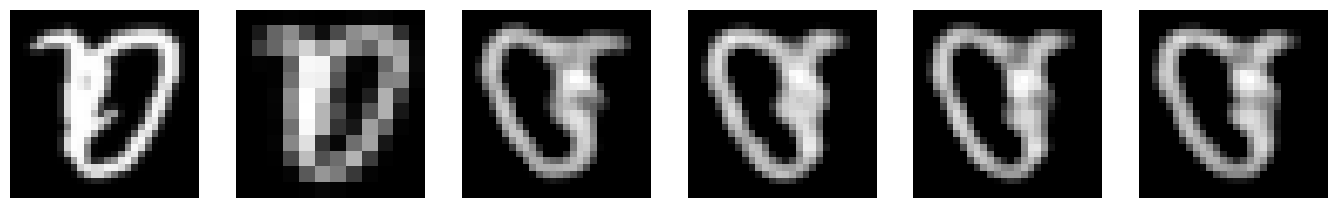

In [32]:
image, small_image, label = test_data[1]
n_samples = 4
print(label)
condition = autoencoder_12x12.encoder(small_image)
cinn.eval()
samples = cinn.sample(n_samples, condition)
reconstructed_images = [autoencoder_28x28.decoder(sample).detach() for sample in samples]

fig, ax = plt.subplots(1, n_samples+2, figsize=(17, 5)) # Create a figure and a set of subplots

# Rotate and flip the original image
rotated_flipped_image = torch.rot90(image, k=1, dims=[-2, -1])  # Rotate 90 degrees anticlockwise
rotated_flipped_image = torch.flip(rotated_flipped_image, dims=[-1])  # Flip horizontally

# Display the rotated and flipped original image
ax[0].imshow(rotated_flipped_image[0], cmap='gray')
ax[0].axis('off')

# Rotate and flip the small image
rotated_flipped_small_image = torch.rot90(small_image, k=1, dims=[-2, -1])  # Rotate 90 degrees anticlockwise
rotated_flipped_small_image = torch.flip(rotated_flipped_small_image, dims=[-1])  # Flip horizontally

# Display the rotated and flipped small image
ax[1].imshow(rotated_flipped_small_image[0, :, :], cmap='gray')
ax[1].axis('off')

for i in range(n_samples):
    # Rotate and flip each reconstructed image
    rotated_flipped_reconstructed = torch.rot90(reconstructed_images[i], k=1, dims=[-2, -1])  # Rotate 90 degrees anticlockwise
    rotated_flipped_reconstructed = torch.flip(rotated_flipped_reconstructed, dims=[-1])  # Flip horizontally
    
    # Display the rotated and flipped reconstructed image
    ax[i+2].imshow(rotated_flipped_reconstructed[0, 0, :, :], cmap='gray')
    ax[i+2].axis('off')

plt.show()

In [22]:
from torch import nn
from tqdm import tqdm
loss = nn.MSELoss()
mse = 0
# correct_predictions = 0
for batch in tqdm(test_loader):
    image, small_image, label = batch
    n_samples = 10

    condition = autoencoder_12x12.encoder(small_image)
    samples = cinn.sample(n_samples, condition)

    reconstructed_images = torch.stack([autoencoder_28x28.decoder(samples[i]).detach() for i in range(n_samples)])
    mean_image = torch.mean(reconstructed_images, dim=0)
    mean_image = mean_image[0]
    mse += loss(mean_image, image).item()

    # output = classifier(mean_image)
    # prediction = torch.argmax(output)
    # correct_predictions += (prediction == label).sum().item()

len_data = len(test_data)
total_mse = mse/len_data
# accuracy = correct_predictions/len_data * 100

# print("Accuracy: ", accuracy)
print("MSE: ", total_mse)

100%|██████████| 116323/116323 [27:52<00:00, 69.56it/s]

MSE:  0.005226282452924482
